In [1]:
import sys
sys.path.append("..")
from helper import *
from word_embeddings import *
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from pprint import pprint
import matplotlib.pyplot as plt
from operator import itemgetter
from gensim.models import Phrases

1. Create preprocessed data

In [2]:
df = transcripts_to_df("../test_transcripts")
preprocess_df(df)
df.head()

,transcriptionName,content,year,month,day
0,tagesschau_26062014_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2014,06,26
1,tagesschau_04012013_2000_.wav.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,01,04
2,tagesschau_02042013_2000_.wav.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,04,02
3,tagesschau_27092013_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,09,27
4,tagesschau_20112013_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,11,20


2. Add to preprocessing: Bigrams

In [3]:
# Remove rare and common tokens.
# Create a dictionary representation of the documents.
docs = list(df["content"])
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=40)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2.5. Extract corpus

In [9]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=80, no_above=0.5)
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2738
Number of documents: 1450


3. Define function to calculate coherence score (evaluation measure) for LDA

In [10]:
def calculate_coherence_for_topicnum_range(corpus, dictionary, start_num, end_num):
    result = []
    temp = dictionary[0]
    id2word = dictionary.id2token
    # Set training parameters.
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    for i in range(start_num, end_num):
        model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=i,
            passes=passes,
            eval_every=eval_every
        )
        #cm = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        #coherence = cm.get_coherence()  # get coherence value
        top_topics = model.top_topics(corpus, dictionary=dictionary) #, num_words=20)
        # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
        avg_topic_coherence = sum([t[1] for t in top_topics]) / i
        print("Coherence for topic num. {}: {}".format(i, avg_topic_coherence))
        result.append((i, avg_topic_coherence))
    return result

4. Calculate coherence scores

In [11]:
results = calculate_coherence_for_topicnum_range(corpus, dictionary, 5, 15)
print('\a')

Coherence for topic num. 5: -0.9801109274386466
Coherence for topic num. 6: -1.0360978738413664
Coherence for topic num. 7: -0.9730068820645628
Coherence for topic num. 8: -1.0037119319991503
Coherence for topic num. 9: -1.0016049039752972
Coherence for topic num. 10: -1.0329624617067275
Coherence for topic num. 11: -1.0356795204676197
Coherence for topic num. 12: -1.085289469372233
Coherence for topic num. 13: -1.105930515117205
Coherence for topic num. 14: -1.0551513366242935



5. Plot coherence values and find highest point (best coherence)

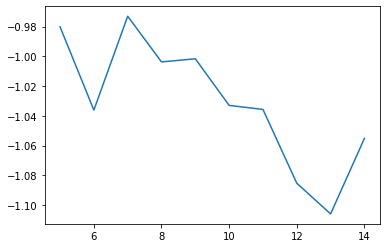

In [12]:
xs = [x[0] for x in results]
ys = [x[1] for x in results]
plt.plot(xs, ys)

6. Show topics of best model

In [13]:
best_num_topics = max(results,key=itemgetter(1))[0]
temp = dictionary[0]
id2word = dictionary.id2token
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=best_num_topics,
    passes=passes,
    eval_every=eval_every
)
top_topics = model.top_topics(corpus, dictionary=dictionary)
pprint(top_topics)

[([(0.005463916, 'minute'),
   (0.0049036318, 'dortmund'),
   (0.0048224693, '0'),
   (0.004726746, 'münchen'),
   (0.0045020017, 'gewinnen'),
   (0.004258057, 'wolfsburg'),
   (0.0042121704, 'leverkusen'),
   (0.0041076047, 'hälfte'),
   (0.004061603, 'platz'),
   (0.003998599, 'schalke'),
   (0.003972159, 'mönchengladbach'),
   (0.003938149, 'bayer'),
   (0.0039059522, 'stuttgart'),
   (0.003889079, 'hannover'),
   (0.0038863928, 'bremen'),
   (0.0035647848, 'spiel'),
   (0.0035434521, 'augsburg'),
   (0.00334095, 'zweit'),
   (0.003327264, 'hamburg'),
   (0.0033253524, 'hoffenheim')],
  -0.7358524688130959),
 ([(0.01238539, 'ukraine'),
   (0.009005217, 'russland'),
   (0.0043203365, 'separatist'),
   (0.0037861294, 'putin'),
   (0.0037625749, 'kampf'),
   (0.0035775935, 'russisch'),
   (0.0034092187, 'moskau'),
   (0.003374853, 'konflikt'),
   (0.003369933, 'russische'),
   (0.0032957443, 'soldat'),
   (0.00314433, 'kiew'),
   (0.0031381377, 'ukrainische'),
   (0.00292677, 'israel')